In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

## 3.1 Автоматическое дифференцирование в `torch`

3.1.1 Воспользовавшись классами `Neuron` и `SquaredLoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [3]:
class Neuron:
  def __init__(self, n_inputs):
    self.n_inputs = n_inputs
    self.weights = torch.randn(n_inputs, requires_grad=True)
    self.bias = torch.randn(1)

  def forward(self, input):
    self.input = input
    return torch.dot(self.weights, input) + self.bias

  def backward(self, dvalue):
    self.dweights = dvalue * self.input # df/dW
    self.dinput =  dvalue * self.weights # df/wX
    self.dbias = dvalue # df/db

In [4]:
class SquaredLoss:

  def forward(self, y_pred, y_true):
    self.loss = (y_pred - y_true)**2
    return self.loss

  def backward(self, y_pred, y_true):
    y_pred = torch.autograd.Variable(y_pred, requires_grad=True)
    y_true = torch.autograd.Variable(y_true, requires_grad=False)
    ((y_pred - y_true)**2).backward()
    self.dinput = y_pred.grad

In [5]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X_1 = torch.from_numpy(X).to(dtype=torch.float32)
y_1 = torch.from_numpy(y).to(dtype=torch.float32)

In [6]:
n_inputs = 4
lr = 0.005
n_epoch = 5_001

neuron = Neuron(n_inputs)
squared_loss = SquaredLoss()

losses = []
for epoch in range(n_epoch):
  for x_example, y_example in zip(X_1, y_1):
    # forward pass
    y_pred = neuron.forward(x_example)
    curr_loss = squared_loss.forward(y_pred, y_example)
    losses.append(curr_loss)
    # backprop
    squared_loss.backward(y_pred, y_example)
    neuron.backward(squared_loss.dinput)
    neuron.weights = neuron.weights - lr * neuron.dweights

    neuron.bias -= lr * neuron.dbias
  if epoch % 500 == 0: print(f'epoch {epoch} mean loss {(sum(losses) / len(losses)).item()}')


epoch 0 mean loss 7955.86181640625
epoch 500 mean loss 18.786361694335938
epoch 1000 mean loss 9.40256404876709
epoch 1500 mean loss 6.2704644203186035
epoch 2000 mean loss 4.703631401062012
epoch 2500 mean loss 3.7632813453674316
epoch 3000 mean loss 3.136276960372925
epoch 3500 mean loss 2.6883652210235596
epoch 4000 mean loss 2.3524036407470703
epoch 4500 mean loss 2.091083526611328
epoch 5000 mean loss 1.8820170164108276


3.1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [7]:
class Activation_ReLU:
  def forward(self, inputs):
    self.inputs = inputs
    self.output = inputs.clip(min=0)
    return self.output

  def backward(self, dvalues):
    self.dinputs = dvalues.clone()
    self.dinputs[self.inputs <= 0] = 0

In [8]:
class MSELoss:
  def forward(self, y_pred, y_true):
    return torch.square(y_true - y_pred).mean()

  def backward(self, y_pred, y_true):
    y_pred = torch.autograd.Variable(y_pred, requires_grad=True)
    y_true = torch.autograd.Variable(y_true, requires_grad=False)
    (torch.square(y_true - y_pred).mean()).backward()
    self.dinput = y_pred.grad

In [9]:
class Linear:
    def __init__(self, n_features, n_neurons):
        # <создать атрибуты объекта weights и biases>
        self.weights = torch.randn(n_neurons, n_features).T
        self.weights.requires_grad = True
        self.biases = torch.randn(n_neurons)

    def forward(self, inputs):
        self.inputs = inputs
        return inputs @ self.weights + self.biases # <реализовать логику слоя>

    def backward(self, dvalues):
        self.dweights = self.inputs.T @ dvalues # df/dW
        self.dbiases = torch.ones(dvalues.shape[0]) @ dvalues # df/db
        self.dinputs = dvalues @ self.weights.T # df/dX

In [10]:
# ДАННЫЕ
X_2 = torch.linspace(0, 1, 100).view(-1, 1)
y_2 = torch.sin(2 * np.pi * X_2) + 0.1 * torch.rand(X_2.size())

In [11]:
# создание компонентов сети
linear1 = Linear(1, 10)
relu1 = Activation_ReLU()
linear2 = Linear(10, 1)

mse_loss = MSELoss()
lr = 0.005
n_epoch = 2_501

losses_list = []
for epoch in range(n_epoch):
  # <forward pass>
  # fc1 > relu1 > fc2 > loss
  linear1_forward = linear1.forward(X_2)
  relu1_forward = relu1.forward(linear1_forward)
  linear2_forward = linear2.forward(relu1_forward)
  data_loss = mse_loss.forward(linear2_forward, y_2) # <прогон через функцию потерь>
  losses_list.append(data_loss.item())

  if epoch % 500 == 0:
    print(f'epoch {epoch} mean loss {np.mean(losses_list)}')

  # <backprop>
  # loss > fc2 > relu1 > fc1
  mse_loss.backward(linear2_forward, y_2)
  linear2.backward(mse_loss.dinput)
  relu1.backward(linear2.dinputs)
  linear1.backward(relu1.dinputs)

  # <шаг оптимизации для fc1>
  linear1.weights = linear1.weights - lr * linear1.dweights
  linear1.biases = linear1.biases - lr * linear1.dbiases

  # <шаг оптимизации для fc2>
  linear2.weights = linear2.weights - lr * linear2.dweights
  linear2.biases = linear2.biases - lr * linear2.dbiases

epoch 0 mean loss 1.9983086585998535
epoch 500 mean loss 0.3385916453695107
epoch 1000 mean loss 0.25128464214689844
epoch 1500 mean loss 0.21911496001430386
epoch 2000 mean loss 0.2018897361468816
epoch 2500 mean loss 0.19068185798004597


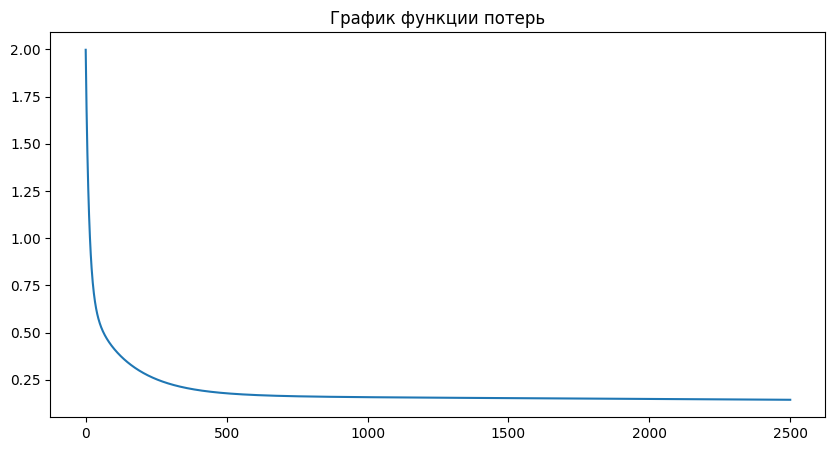

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_list)), losses_list)
plt.title("График функции потерь")
plt.show()

Text(0, 0.5, '$y$')

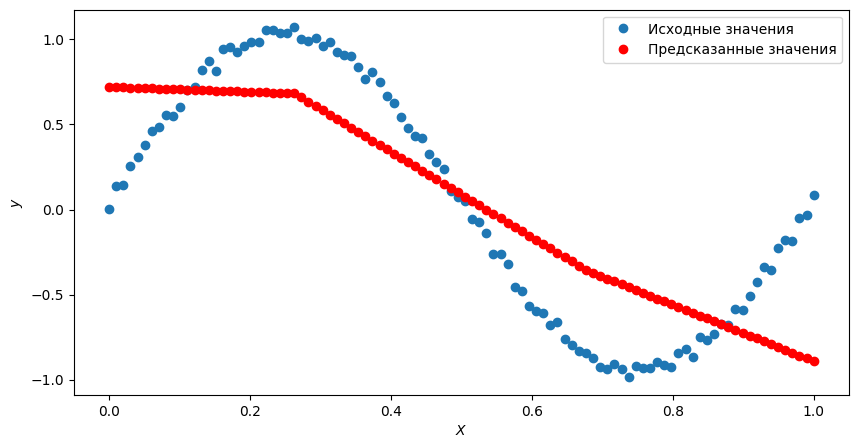

In [13]:
linear1_forward = linear1.forward(X_2)
relu1_forward = relu1.forward(linear1_forward)
linear2_forward = linear2.forward(relu1_forward)

plt.figure(figsize=(10, 5))
plt.plot(X_2.numpy(), y_2.numpy(), 'o', label='true')
plt.plot(X_2.numpy(), linear2_forward.detach().numpy() , 'o', c='r', label='predicted')
plt.legend(['Исходные значения', 'Предсказанные значения'])
plt.xlabel('$X$')
plt.ylabel('$y$')


## 3.2 Алгоритмы оптимизации в `torch.optim`

3.2.1 Решить задачу 3.1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [14]:
n_inputs = 4
lr = 0.005
n_epoch = 5_001

neuron = Neuron(n_inputs)
squared_loss = SquaredLoss()
optimizer = torch.optim.SGD([neuron.weights, neuron.bias], lr=lr)

losses = []
for epoch in range(n_epoch):
  for x_example, y_example in zip(X_1, y_1):
    # forward pass
    y_pred = neuron.forward(x_example)
    curr_loss = squared_loss.forward(y_pred, y_example)
    losses.append(curr_loss)

    # backprop
    optimizer.zero_grad()
    squared_loss.forward(y_pred, y_example).backward()
    optimizer.step()

  if epoch % 500 == 0: print(f'epoch {epoch} mean loss {(sum(losses) / len(losses)).item()}')

epoch 0 mean loss 7867.17333984375
epoch 500 mean loss 22.062915802001953
epoch 1000 mean loss 12.769501686096191
epoch 1500 mean loss 9.667569160461426
epoch 2000 mean loss 8.115827560424805
epoch 2500 mean loss 7.184534549713135
epoch 3000 mean loss 6.563569068908691
epoch 3500 mean loss 6.119689464569092
epoch 4000 mean loss 5.786061763763428
epoch 4500 mean loss 5.526556968688965
epoch 5000 mean loss 5.318942546844482


3.2.2 Решить задачу 3.1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [15]:
lr = 0.005
n_epoch = 2_501

linear1 = Linear(1, 10)
relu1 = Activation_ReLU()
linear2 = Linear(10, 1)
optimizer1 = torch.optim.Adam([linear1.weights, linear1.biases], lr=lr)
optimizer2 = torch.optim.Adam([linear2.weights, linear2.biases], lr=lr)
mse_loss = MSELoss()

losses_list = []

for epoch in range(n_epoch):
  optimizer1.zero_grad()
  optimizer2.zero_grad()
  # <forward pass>
  # fc1 > relu1 > fc2 > loss
  linear1_forward = linear1.forward(X_2)
  relu1_forward = relu1.forward(linear1_forward)
  linear2_forward = linear2.forward(relu1_forward)
  data_loss = mse_loss.forward(linear2_forward, y_2) # <прогон через функцию потерь>
  losses_list.append(data_loss.item())

  optimizer1.zero_grad()
  optimizer2.zero_grad()
  mse_loss.forward(linear2_forward, y_2).backward()
  optimizer1.step()
  optimizer2.step()

  if epoch % 500 == 0: print(f'epoch {epoch} mean loss {np.mean(losses_list)}')

epoch 0 mean loss 1.6538891792297363
epoch 500 mean loss 0.36714058150788265
epoch 1000 mean loss 0.27264722453785706
epoch 1500 mean loss 0.24028073657281712
epoch 2000 mean loss 0.22332632628784724
epoch 2500 mean loss 0.21248662147055813


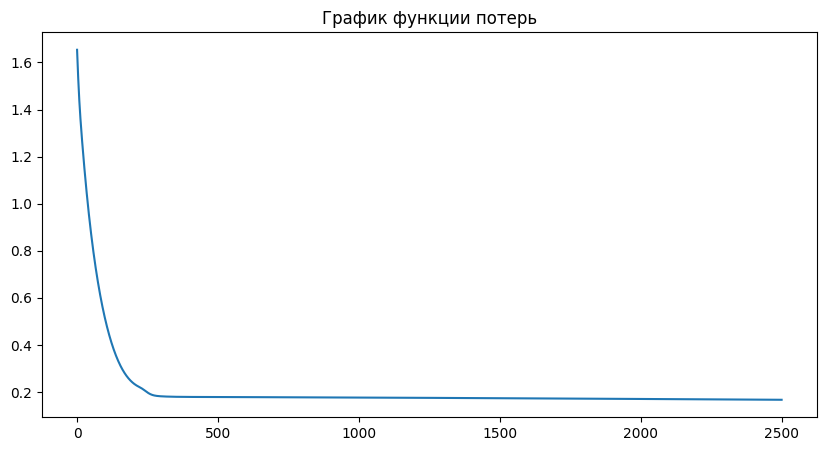

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_list)), losses_list)
plt.title("График функции потерь")
plt.show()

Text(0, 0.5, '$y$')

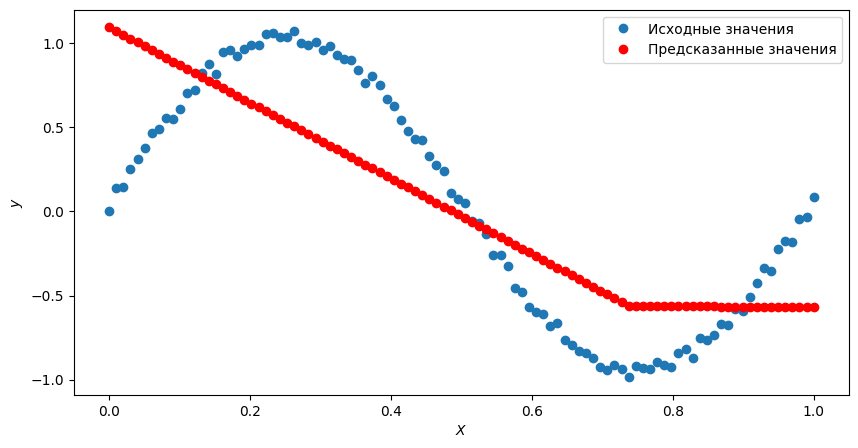

In [17]:
linear1_forward = linear1.forward(X_2)
relu1_forward = relu1.forward(linear1_forward)
linear2_forward = linear2.forward(relu1_forward)

plt.figure(figsize=(10, 5))
plt.plot(X_2.numpy(), y_2.numpy(), 'o', label='true')
plt.plot(X_2.numpy(), linear2_forward.detach().numpy() , 'o', c='r', label='predicted')
plt.legend(['Исходные значения', 'Предсказанные значения'])
plt.xlabel('$X$')
plt.ylabel('$y$')

## 3.3 Построение сетей при помощи `torch.nn`

3.3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [18]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [19]:
class SineNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = nn.Linear(1, n_hidden_neurons)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

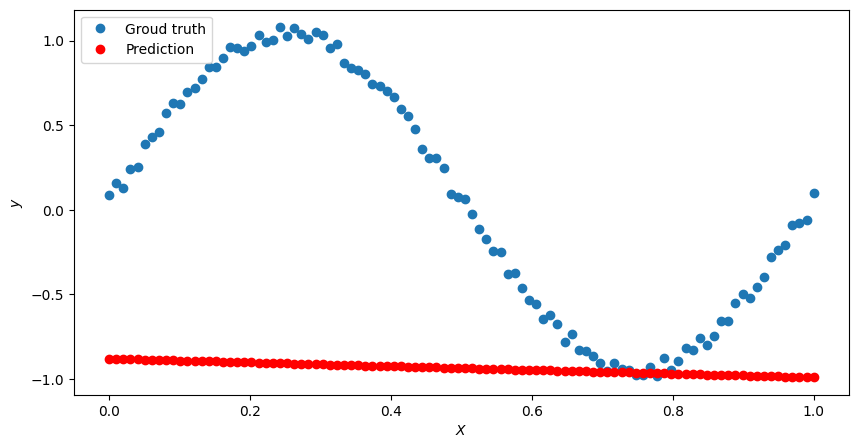

In [20]:
# начальное предсказание
def predict(net, X, y):
    y_pred = net.forward(X)

    plt.figure(figsize=(10, 5))
    plt.plot(X.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(X.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$X$')
    plt.ylabel('$y$')

n_hidden_neurons = 5
sine_net = SineNet(n_hidden_neurons)
predict(sine_net, X, y)

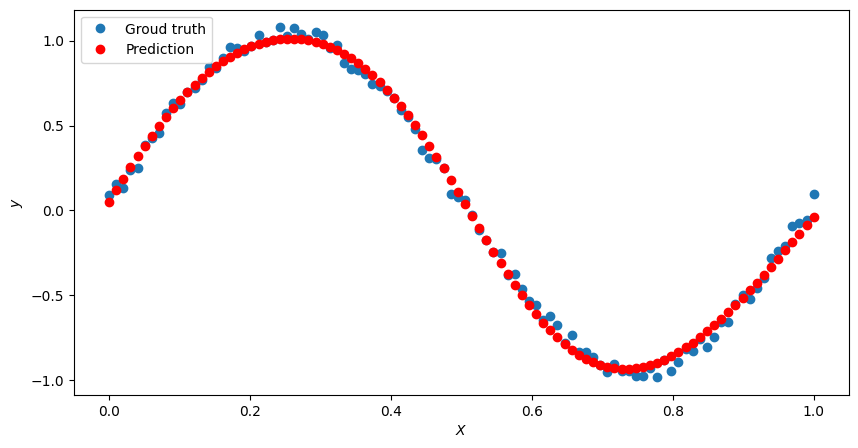

In [21]:
# после обучения
n_epoch = 2_701
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.015)
MSE_loss_fn = nn.MSELoss()

for epoch_index in range(n_epoch):
    optimizer.zero_grad()
    y_pred = sine_net.forward(X)
    loss_val = MSE_loss_fn(y_pred, y)
    loss_val.backward()
    optimizer.step()

predict(sine_net, X, y)

3.3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim`

In [22]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(3 * np.pi * X) + 0.1 * torch.rand(X.size())

In [23]:
class SequentialNet(nn.Sequential):
    def __init__(self, n_hidden_neurons):
        super(SequentialNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, n_hidden_neurons),
            nn.Sigmoid(),
            nn.Linear(n_hidden_neurons, 1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

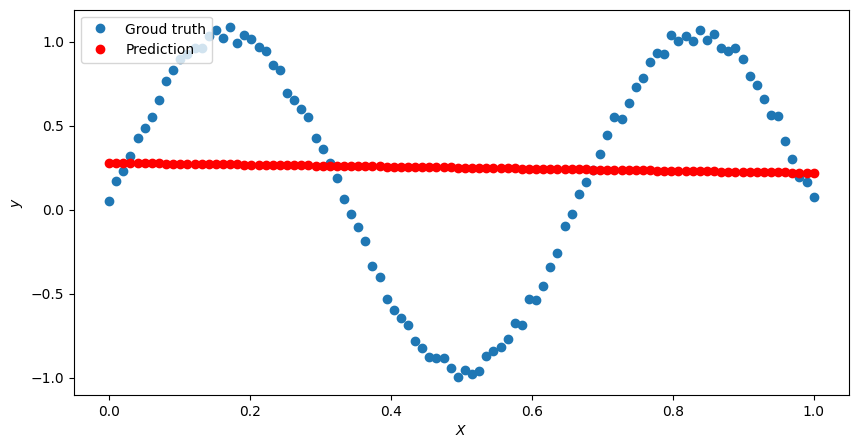

In [24]:
# начальное предсказание
n_hidden_neurons = 5
sequential_net = SequentialNet(n_hidden_neurons)
predict(sequential_net, X, y)

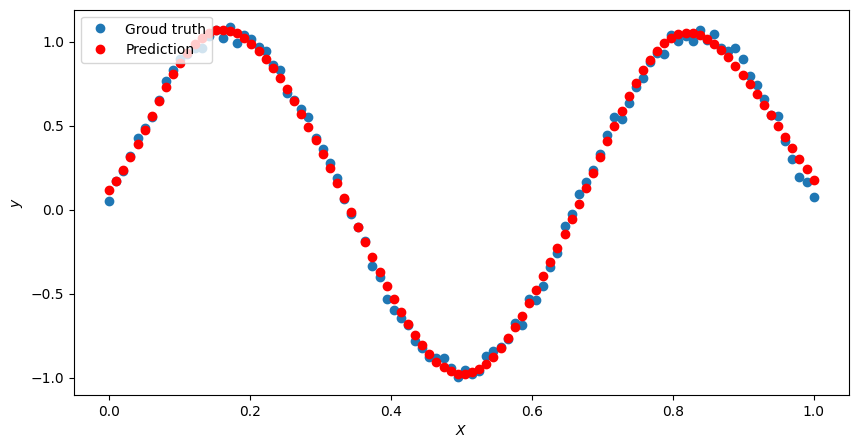

In [25]:
# после обучения
optimizer = torch.optim.Adam(sequential_net.parameters(), lr=0.015)
n_epoch = 2_701
MSE_loss_fn = nn.MSELoss()

for epoch_index in range(n_epoch):
    optimizer.zero_grad()
    y_pred = sequential_net.forward(X)
    loss_val = MSE_loss_fn(y_pred, y)
    loss_val.backward()
    optimizer.step()

predict(sequential_net, X, y)

## 3.4. Datasets and dataloaders

3.4.1 Создать датасет, поставляющий данные из задачи 3.1.2.

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.3.1 (или 3.3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [26]:
import torch.utils.data as data_utils
import torch.nn as nn

In [27]:
class SinDataset(data_utils.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

In [28]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())
train = SinDataset(X, y)
train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

In [29]:
display(train[2])
len(train)

(tensor([0.0202]), tensor([0.1683]))

100

In [30]:
# Обучите модель, пользуясь мини-пакетным градиентным спуском с
# размером пакета (batch_size) = 10

n_epoch = 2_001
n_hidden_neurons = 5
MSE_loss_fn = nn.MSELoss()
sequential_net = SequentialNet(n_hidden_neurons)
losses_list = []

for epoch in range(n_epoch):
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        optimizer = torch.optim.Adam(sequential_net.parameters(), lr=0.015)
        optimizer.zero_grad()
        outputs = sequential_net(inputs)
        loss = MSE_loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch % 250 == 0: print(f'epoch {epoch} => {running_loss}')
print('Finished')

epoch 0 => 5.50890639424324
epoch 250 => 1.07652260735631
epoch 500 => 0.46286436077207327
epoch 750 => 0.24493555910885334
epoch 1000 => 0.07472856459207833
epoch 1250 => 0.046266455901786685
epoch 1500 => 0.03838749579153955
epoch 1750 => 0.027710274211131036
epoch 2000 => 0.03195113968104124
Finished


3.4.2 Предсказание цен алмазов

3.4.2.1 Создайте датасет на основе файла diamonds.csv.

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

In [31]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [32]:
!ls "/content/drive/MyDrive/ML/3/diamonds.csv"

/content/drive/MyDrive/ML/3/diamonds.csv


In [33]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ML/3/diamonds.csv', index_col=0)
df

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [34]:
df.dtypes[df.dtypes == object]

cut        object
color      object
clarity    object
dtype: object

In [35]:
df.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)
df.dtypes

carat    float64
depth    float64
table    float64
price      int64
x        float64
y        float64
z        float64
dtype: object

In [36]:
df.head(2)

,carat,depth,table,price,x,y,z
1,0.23,61.5,55.0,326,3.95,3.98,2.43
2,0.21,59.8,61.0,326,3.89,3.84,2.31


In [37]:
df.columns.tolist()

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

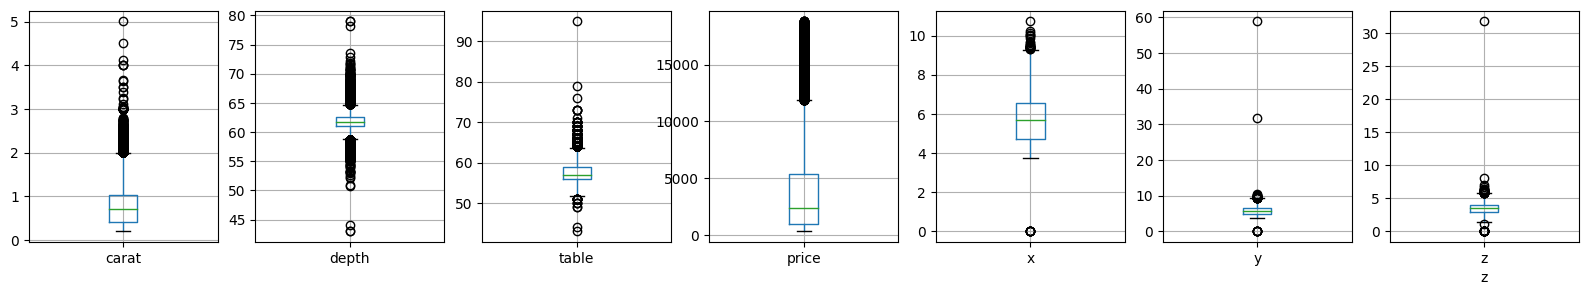

In [38]:
listvar = df.columns.tolist()
fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
counter=0
for ax in axes:
    df.boxplot(column=listvar[counter], ax=axes[counter])
    plt.xlabel(listvar[counter])
    counter = counter+1
plt.show()

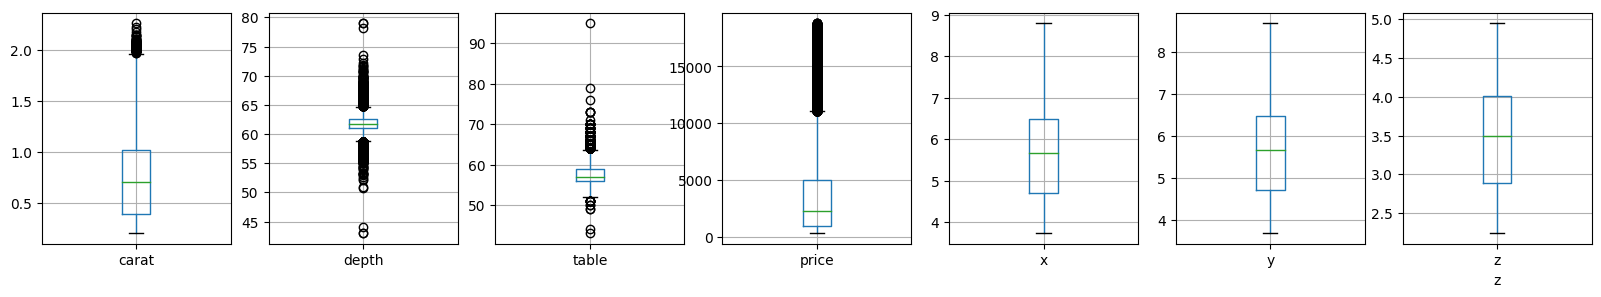

In [39]:
from scipy import stats

z = 2
for var in listvar:
    df1 = df[np.abs(stats.zscore(df[var])) < z]

fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
counter=0
for ax in axes:
    df1.boxplot(column=listvar[counter], ax=axes[counter])
    plt.xlabel(listvar[counter])
    counter = counter+1
plt.show()

In [40]:
df = df1

In [41]:
class DiamondsDataset(data_utils.Dataset):
  def __init__(self, data):
    self.X = data.drop(['price'], axis=1)
    self.X = torch.from_numpy(self.X.to_numpy())
    self.y = data['price']
    self.y = torch.from_numpy(self.y.to_numpy())

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx:idx+1], self.y[idx:idx+1]

3.4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.


In [42]:
data_set = DiamondsDataset(df)

train_size = int(data_set.__len__()  * 0.8)
train_set, test_set = data_utils.random_split(data_set,
                                              [train_size,
                                               data_set.__len__() - train_size])

3.4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`).

In [43]:
train_set_loader = data_utils.DataLoader(train_set, batch_size=256, shuffle=True)
test_set_loader = data_utils.DataLoader(test_set, batch_size=256, shuffle=True)

Text(0, 0.5, '$price$')

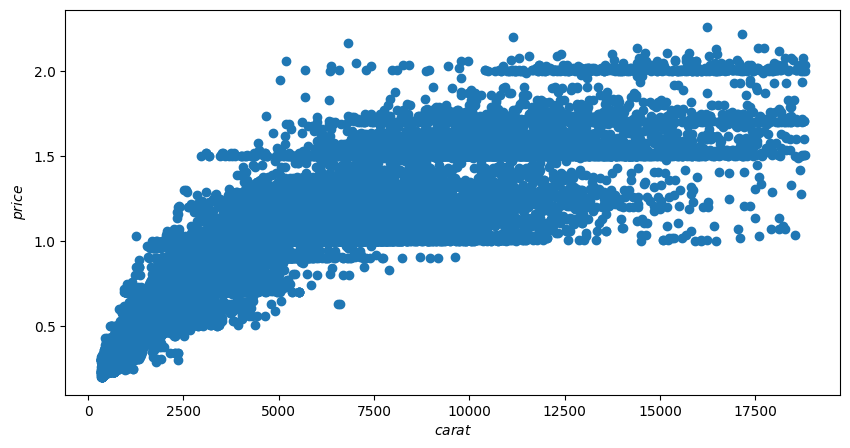

In [44]:
plt.figure(figsize=(10, 5))
plt.scatter(df.price, df.carat)
plt.xlabel('$carat$')
plt.ylabel('$price$')

In [45]:
class SineNet_relu(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet_relu, self).__init__()
        self.fc1 = nn.Linear(6, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(n_hidden_neurons, int(n_hidden_neurons/2))
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(int(n_hidden_neurons/2), 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [46]:
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [47]:
n_epoch = 1000 + 1
lr=0.001
mse = nn.HuberLoss()
# mse = nn.MSELoss()

n_hidden_neurons = 42
sine_net_relu = SineNet_relu(n_hidden_neurons)
optimizer = torch.optim.ASGD(sine_net_relu.parameters(), lr=lr, lambd =0.00001,
                             weight_decay=0.001)
losses_list = []

log_interval = 50

start = time.time()
for epoch in range(n_epoch):
    losses = []
    for inputs, target in train_set_loader:
        optimizer.zero_grad()
        outputs = sine_net_relu(inputs.float())
        loss = mse(outputs.reshape(-1, 1), target.float())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    losses_list.append(np.mean(losses))
    if epoch % log_interval == 0:
      print("Epoch: {}/{} ({:.2f})%|".format(epoch, n_epoch-1, epoch / n_epoch * 100),
            "{}|".format(time_since(start)),
            "Training loss: {:.3f}..".format(np.mean(losses)))
print('Finished Training')

Epoch: 0/1000 (0.00)%| 0m 1s| Training loss: 2642.219..
Epoch: 50/1000 (5.00)%| 0m 46s| Training loss: 1200.062..
Epoch: 100/1000 (9.99)%| 1m 25s| Training loss: 991.792..
Epoch: 150/1000 (14.99)%| 2m 4s| Training loss: 907.347..
Epoch: 200/1000 (19.98)%| 2m 42s| Training loss: 870.379..
Epoch: 250/1000 (24.98)%| 3m 21s| Training loss: 852.609..
Epoch: 300/1000 (29.97)%| 4m 1s| Training loss: 843.725..
Epoch: 350/1000 (34.97)%| 4m 40s| Training loss: 854.564..
Epoch: 400/1000 (39.96)%| 5m 17s| Training loss: 829.619..
Epoch: 450/1000 (44.96)%| 5m 56s| Training loss: 821.063..
Epoch: 500/1000 (49.95)%| 6m 35s| Training loss: 818.120..
Epoch: 550/1000 (54.95)%| 7m 15s| Training loss: 802.616..
Epoch: 600/1000 (59.94)%| 7m 52s| Training loss: 804.499..
Epoch: 650/1000 (64.94)%| 8m 30s| Training loss: 813.015..
Epoch: 700/1000 (69.93)%| 9m 9s| Training loss: 805.469..
Epoch: 750/1000 (74.93)%| 9m 46s| Training loss: 807.416..
Epoch: 800/1000 (79.92)%| 10m 24s| Training loss: 807.081..
Epoc

3.4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке.


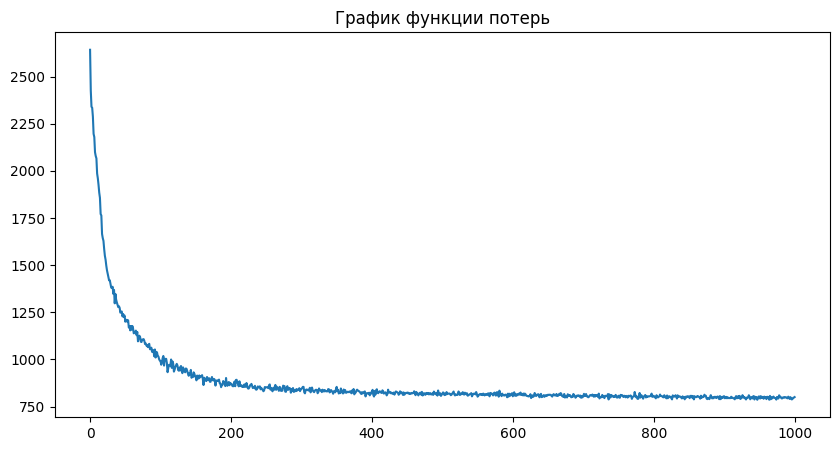

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_list)), losses_list)
plt.title("График функции потерь")
plt.show()

In [49]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.1 MB/s eta 0:00:00


In [50]:
from torchmetrics import R2Score, MeanSquaredError, MeanAbsoluteError
from torchmetrics.functional import mean_absolute_percentage_error

mse= []
mae = []
mape = []
r2_s = []
# for inputs, target in test_set_loader:
for inputs, target in train_set_loader:
    preds = sine_net_relu(inputs.float())
    preds = torch.squeeze(preds, 1)

    r2score = R2Score()
    r2_s.append(r2score(preds, target).detach().numpy())

    mean_squared_error = MeanSquaredError()
    mse.append(mean_squared_error(preds, target).detach().numpy())

    mean_absolute_error = MeanAbsoluteError()
    mae.append(mean_absolute_error(preds, target).detach().numpy())

    mape.append(mean_absolute_percentage_error(preds, target).detach().numpy())

print(f'R2 => {np.mean(r2_s)}')
print(f'MAE => {np.mean(mae)}')
print(f'MSE => {np.mean(mse)}')
print(f'MAPE => {np.mean(mape)}')

R2 => 0.8452487587928772
MAE => 770.7449951171875
MSE => 1847000.875
MAPE => 0.2263355851173401


3.4.3 Модифицируйте метод `__init__` датасета из 3.4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [51]:
class DiamondsDataset(data_utils.Dataset):
  def __init__(self, X, y, transform):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    sample = self.X[idx], self.y[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [52]:
class DropColsTransform:
  def __init__(self, drop):
    self.drop = drop

  def __call__(self, sample):
    X, y = sample
    X = np.delete(X, self.drop)  # <удаление из X столбцов self.drop>
    return X, y

In [53]:
class ToTensorTransform:
  def __call__(self, sample):
    X, y = sample
    # <преобразование X и y в тензоры>
    X = torch.tensor(X.astype(float)).requires_grad_(True)
    y = torch.tensor(y.astype(float)).requires_grad_(True)
    return X, y

In [54]:
from torchvision import transforms
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ML/3/diamonds.csv', index_col=0)
df.head()


,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [55]:
drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(df.drop(['price'], axis=1).to_numpy(),
                          df['price'].to_numpy(),
                          transforms.Compose([drop, to_tensor]))

In [56]:
dataset[1]

(tensor([ 0.2100, 59.8000, 61.0000,  3.8900,  3.8400,  2.3100],
        dtype=torch.float64, requires_grad=True),
 tensor(326., dtype=torch.float64, requires_grad=True))